# San Francisco Crime prediction 
# Based on 2 layer neural net and count featurizer

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

Import data

In [2]:
trainDF=pd.read_csv("../../train.csv")

Clean up wrong X and Y values (very few of them)

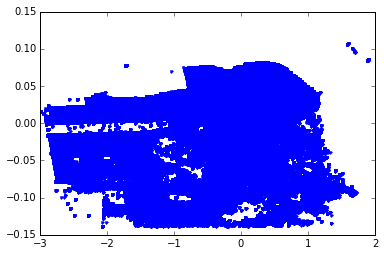

In [3]:
xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(trainDF[["X","Y"]])
trainDF[["X","Y"]]=xy_scaler.transform(trainDF[["X","Y"]])
trainDF=trainDF[abs(trainDF["Y"])<100]
trainDF.index=range(len(trainDF))
plt.plot(trainDF["X"],trainDF["Y"],'.')
plt.show()

Make plots for each crime label

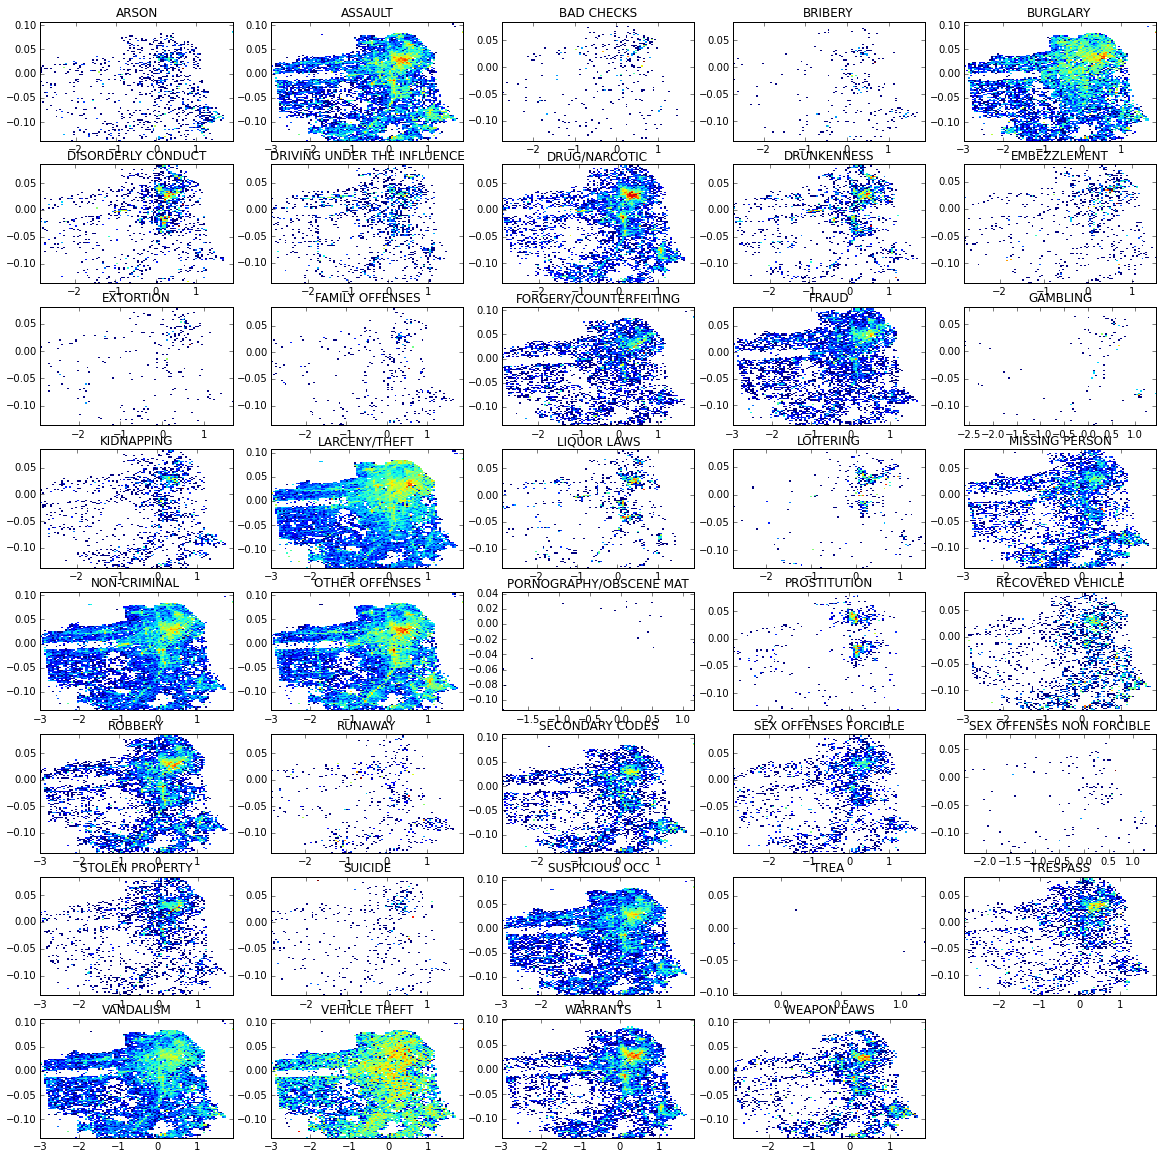

In [4]:
NX=100
NY=100
groups = trainDF.groupby('Category')
ii=1
plt.figure(figsize=(20, 20))
for name, group in groups:
    plt.subplot(8,5,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

# Now proceed as before

In [5]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [6]:
def parse_data(df,logodds,logoddsPA):
    feature_list=df.columns.tolist()
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    print "Creating address features"
    address_features=cleanData["Address"].apply(lambda x: logodds[x])
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
#     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))
    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    cleanData["IsInterection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    feature_list=cleanData.columns.tolist()
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(take_last=True)).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

This part is slower than it needs to be.

In [7]:
addresses=sorted(trainDF["Address"].unique())
categories=sorted(trainDF["Category"].unique())
C_counts=trainDF.groupby(["Category"]).size()
A_C_counts=trainDF.groupby(["Address","Category"]).size()
A_counts=trainDF.groupby(["Address"]).size()
logodds={}
logoddsPA={}
MIN_CAT_COUNTS=2
default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))
for addr in addresses:
    PA=A_counts[addr]/float(len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    for cat in A_C_counts[addr].keys():
        if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
            PA=A_C_counts[addr][cat]/float(A_counts[addr])
            logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
    logodds[addr]=pd.Series(logodds[addr])
    logodds[addr].index=range(len(categories))

In [8]:
features, labels=parse_data(trainDF,logodds,logoddsPA)

Creating address features
Parsing dates
Creating one-hot variables
droping processed columns
joining one-hot features
creating new features


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
print features.columns.tolist()
print len(features.columns)

['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'IsInterection', 'logoddsPA', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'DAY_Friday', 'DAY_Monday', 'DAY_Saturday', 'DAY_Sunday', 'DAY_Thursday', 'DAY_Tuesday', 'DAY_Wednesday', 'logodds0', 'logodds1', 'logodds2', 'logodds3', 'logodds4', 'logodds5', 'logodds6', 'logodds7', 'logodds8', 'logodds9', 'logodds10', 'logodds11', 'logodds12', 'logodds13', 'logodds14', 'logodds15', 'logodds16', 'logodds17', 'logodds18', 'logodds19', 'logodds20', 'logodds21', 'logodds22', 'logodds23', 'logodds24', 'logodds25', 'logodds26', 'logodds27', 'logodds28', 'logodds29', 'logodds30', 'logodds31', 'logodds32', 'logodds33', 'logodds34', 'logodds35', 'logodds36', 'logodds37', 'logodds38', 'IsDup', 'Awake', 'Summer', 'Fall', 'Winter', 'Spring']
70


In [10]:
# num_feature_list=["Time","Day","Month","Year","DayOfWeek"]
collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)

[ 0.07714363  0.06267647  0.04861061  0.04300871  0.03340587  0.03085896
  0.02834616  0.02731142  0.02509795  0.02393235  0.02272111  0.02029053
  0.02000664  0.019452    0.01918369  0.01820193  0.01729548  0.01724542
  0.01715838  0.01714426  0.01703779  0.01695665  0.01668107  0.01651773
  0.01626539  0.01588035  0.01489293  0.01472615  0.01422875  0.01412131
  0.0136947   0.01330571  0.01234474  0.01181851  0.01158515  0.01126484
  0.01104143  0.0105683   0.01032344  0.00943963  0.00903894  0.00838257
  0.00819149  0.00795652  0.0074206   0.00726109  0.00707183  0.00675531
  0.0067189   0.00646287  0.00634686  0.00612685  0.0060737   0.00556134
  0.00526841  0.00516993  0.0048638   0.00452517  0.00417899  0.00407036]


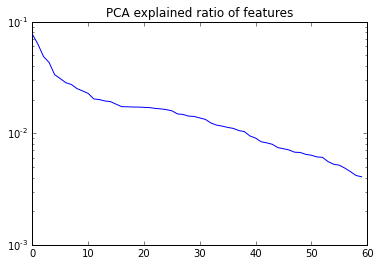

In [11]:
new_PCA=PCA(n_components=60)
new_PCA.fit(features)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
print new_PCA.explained_variance_ratio_

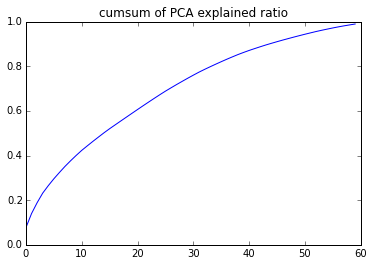

In [12]:
plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")

PCA is interesting, here to play with it more

In [13]:
# features=new_PCA.transform(features)
# features=pd.DataFrame(features)

In [22]:
sss = StratifiedShuffleSplit(labels, train_size=0.5)
for train_index, test_index in sss:
    features_train,features_test=features.iloc[train_index],features.iloc[test_index]
    labels_train,labels_test=labels[train_index],labels[test_index]
features_test.index=range(len(features_test))
features_train.index=range(len(features_train))
labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
features.index=range(len(features))
labels.index=range(len(labels))

In [15]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=32,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=np_utils.to_categorical(y_train.cat.rename_categories(range(len(y_train.unique()))))
#     print output_dim
    model = Sequential()
    model.add(Dense(input_dim, hn, init='glorot_uniform'))
    model.add(PReLU((hn,)))
    model.add(Dropout(dp))

    for i in range(layers):
      model.add(Dense(hn, hn, init='glorot_uniform'))
      model.add(PReLU((hn,)))
      model.add(BatchNormalization((hn,)))
      model.add(Dropout(dp))

    model.add(Dense(hn, output_dim, init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=np_utils.to_categorical(y_test.cat.rename_categories(range(len(y_test.unique()))))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

In [16]:
len(features.columns)

70

In [17]:
N_EPOCHS=20
N_HN=128
N_LAYERS=1
DP=0.5

In [18]:
score, fitting, model = build_and_fit_model(features_train.as_matrix(),labels_train,X_test=features_test.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Train on 438991 samples, validate on 438988 samples
Epoch 0
33s - loss: 2.3470 - val_loss: 2.2305
Epoch 1
34s - loss: 2.2776 - val_loss: 2.2194
Epoch 2
33s - loss: 2.2687 - val_loss: 2.2133
Epoch 3
40s - loss: 2.2616 - val_loss: 2.2096
Epoch 4
37s - loss: 2.2581 - val_loss: 2.2071
Epoch 5
40s - loss: 2.2553 - val_loss: 2.2043
Epoch 6
40s - loss: 2.2529 - val_loss: 2.2023
Epoch 7
38s - loss: 2.2499 - val_loss: 2.2019
Epoch 8
35s - loss: 2.2488 - val_loss: 2.2011
Epoch 9
35s - loss: 2.2479 - val_loss: 2.1988
Epoch 10
35s - loss: 2.2451 - val_loss: 2.1975
Epoch 11
39s - loss: 2.2431 - val_loss: 2.1956
Epoch 12
36s - loss: 2.2425 - val_loss: 2.1955
Epoch 13
35s - loss: 2.2426 - val_loss: 2.1938
Epoch 14
37s - loss: 2.2401 - val_loss: 2.1952
Epoch 15
36s - loss: 2.2400 - val_loss: 2.1926
Epoch 16
36s - loss: 2.2392 - val_loss: 2.1925
Epoch 17
39s - loss: 2.2382 - val_loss: 2.1909
Epoch 18
35s - loss: 2.2384 - val_loss: 2.1913
Epoch 19
38s - loss: 2.2370 - val_loss: 2.1907


In [24]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

 all 2.20831236726
train 2.18018233454
test 2.18310275473


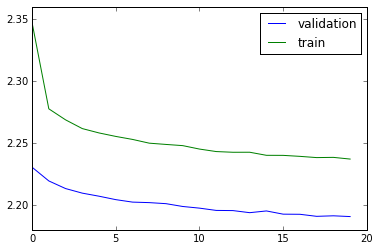

In [28]:
plt.plot(fitting.history['val_loss'],label="validation")
plt.plot(fitting.history['loss'],label="train")
# plt.xscale('log')
plt.legend()

Now train the final model

In [29]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Epoch 0
55s - loss: 2.3152
Epoch 1
52s - loss: 2.2672
Epoch 2
53s - loss: 2.2591
Epoch 3
54s - loss: 2.2545
Epoch 4
55s - loss: 2.2507
Epoch 5
56s - loss: 2.2490
Epoch 6
56s - loss: 2.2468
Epoch 7
58s - loss: 2.2447
Epoch 8
69s - loss: 2.2430
Epoch 9
63s - loss: 2.2424
Epoch 10
60s - loss: 2.2409
Epoch 11
58s - loss: 2.2414
Epoch 12
57s - loss: 2.2401
Epoch 13
58s - loss: 2.2395
Epoch 14
60s - loss: 2.2388
Epoch 15
67s - loss: 2.2378
Epoch 16
58s - loss: 2.2379
Epoch 17
64s - loss: 2.2373
Epoch 18
58s - loss: 2.2367
Epoch 19
63s - loss: 2.2370


In [30]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

all 2.20350119735
train 2.17428331289
test 2.17730264602


In [31]:
testDF=pd.read_csv("../../test.csv")
testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
#set outliers to 0
testDF["X"]=testDF["X"].apply(lambda x: 0 if abs(x)>5 else x)
testDF["Y"]=testDF["Y"].apply(lambda y: 0 if abs(y)>5 else y)

In [32]:
new_addresses=sorted(testDF["Address"].unique())
new_A_counts=testDF.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_A_counts[addr]/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(A_counts[addr]+new_A_counts[addr])/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [33]:
features_sub, _=parse_data(testDF,logodds,logoddsPA)
# scaler.fit(features_test)

Creating address features
Parsing dates
Creating one-hot variables
droping processed columns
joining one-hot features
creating new features


In [34]:
collist=features_sub.columns.tolist()
print collist

['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'IsInterection', 'logoddsPA', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'DAY_Friday', 'DAY_Monday', 'DAY_Saturday', 'DAY_Sunday', 'DAY_Thursday', 'DAY_Tuesday', 'DAY_Wednesday', 'logodds0', 'logodds1', 'logodds2', 'logodds3', 'logodds4', 'logodds5', 'logodds6', 'logodds7', 'logodds8', 'logodds9', 'logodds10', 'logodds11', 'logodds12', 'logodds13', 'logodds14', 'logodds15', 'logodds16', 'logodds17', 'logodds18', 'logodds19', 'logodds20', 'logodds21', 'logodds22', 'logodds23', 'logodds24', 'logodds25', 'logodds26', 'logodds27', 'logodds28', 'logodds29', 'logodds30', 'logodds31', 'logodds32', 'logodds33', 'logodds34', 'logodds35', 'logodds36', 'logodds37', 'logodds38', 'IsDup', 'Awake', 'Summer', 'Fall', 'Winter', 'Spring']


In [35]:
features_sub[collist]=scaler.transform(features_sub[collist])

In [36]:
predDF=pd.DataFrame(model.predict_proba(features_sub.as_matrix(),verbose=0),columns=sorted(labels.unique()))

In [37]:
predDF.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.004689,0.098936,0.000187,0.000129,0.062209,0.003510,0.001250,0.021802,0.001641,0.000773,...,0.000538,0.001224,0.001094,0.046618,2.101852e-06,0.006748,0.094425,0.123388,0.030323,0.007257
1,0.002153,0.083348,0.000027,0.000086,0.000938,0.001392,0.005868,0.050063,0.002007,0.000026,...,0.000030,0.001069,0.000023,0.021384,3.896940e-08,0.000725,0.032963,0.063096,0.070983,0.019628
2,0.002262,0.028248,0.000174,0.000017,0.259758,0.001492,0.001225,0.003016,0.000441,0.001183,...,0.000039,0.000734,0.000773,0.027552,1.380572e-07,0.004622,0.078929,0.179449,0.006987,0.001500
3,0.000961,0.217098,0.000141,0.003030,0.009785,0.007843,0.002701,0.125863,0.024627,0.000194,...,0.000126,0.012048,0.000485,0.025891,5.712422e-07,0.007958,0.032432,0.005983,0.082637,0.058221
4,0.000961,0.217098,0.000141,0.003030,0.009785,0.007843,0.002701,0.125863,0.024627,0.000194,...,0.000126,0.012048,0.000485,0.025891,5.712422e-07,0.007958,0.032432,0.005983,0.082637,0.058221


In [38]:
predDF.to_csv("crimeSF_NN_logodds.csv",index_label="Id",na_rep="0")